# SNN-CLAPP

In [1]:
import matplotlib.pyplot as plt
from utils import load_NMNIST, load_PMNIST, train, test
from model import CLAPP_SNN
import numpy as np
import torch
import seaborn as sns
color_list = sns.color_palette()
device = 'cpu'
epochs = 1
batch_size = 1
n_inputs = 28*28 #34 * 34 * 2
n_hidden = 2 * [512]
n_outputs = 10
folder = 'models/'
model_name = folder + 'SNN_CLAPP_0'


/home/lars/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset
N-MNIST 


torch.Size([1, 4, 784]) tensor([7])


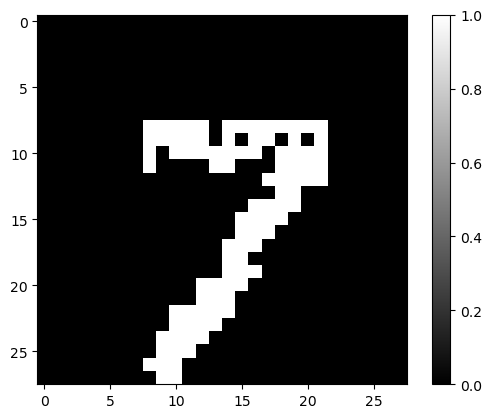

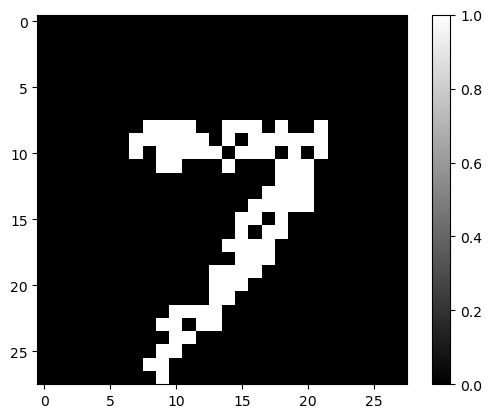

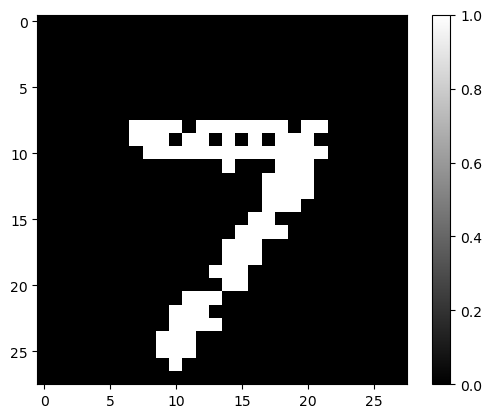

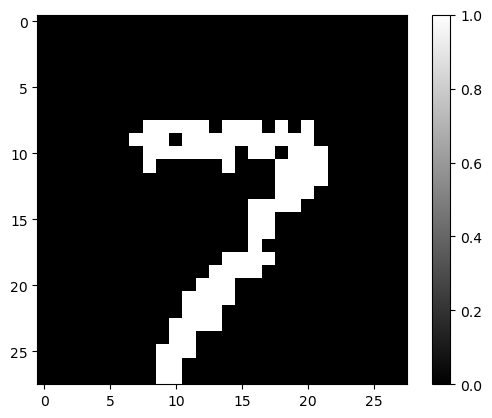

In [2]:
n_time_bins = 4
train_loader, test_loader = load_PMNIST(n_time_bins, scale=0.9) #load_NMNIST(n_time_bins, batch_size=batch_size)

# Plot Example
frames, target = next(iter(train_loader))
print(frames.shape, target)
for i in range(n_time_bins):
    plt.figure()
    plt.imshow(frames[0,i].view(28,28), cmap='gray')
    plt.colorbar()


## Load pretrained model

In [3]:

SNN = CLAPP_SNN(n_inputs, n_hidden, n_outputs).to(device)
SNN.load_state_dict(torch.load(model_name, map_location='cpu'))

<All keys matched successfully>

In [14]:
losses, loss_per_digit, clapp_activation, target_list, clapp_losses = test(SNN, test_loader, device)
print(loss_per_digit)
print('Mean Loss:', losses.sum()/10000)

# mean loss for const prediction: 2.3

10000it [04:37, 36.00it/s]


[tensor(1726.4492), tensor(1297.9918), tensor(1393.0643), tensor(5268.7222), tensor(5077.4321), tensor(4651.1094), tensor(5037.1665), tensor(1238.2253), tensor(5035.7070), tensor(5206.1987)]
Mean Loss: tensor(3.5932)


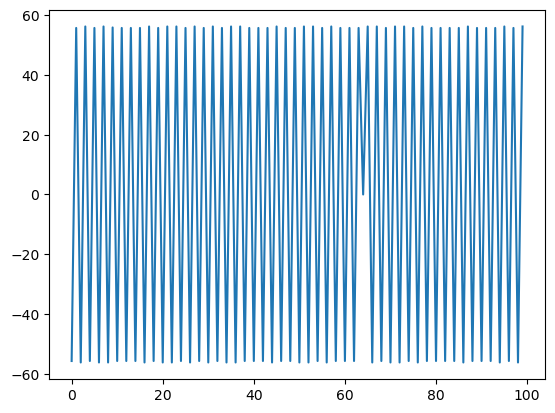

In [13]:
plt.plot(torch.stack(clapp_losses).detach().cpu()[:100,1])

# Analyze Weights Directly

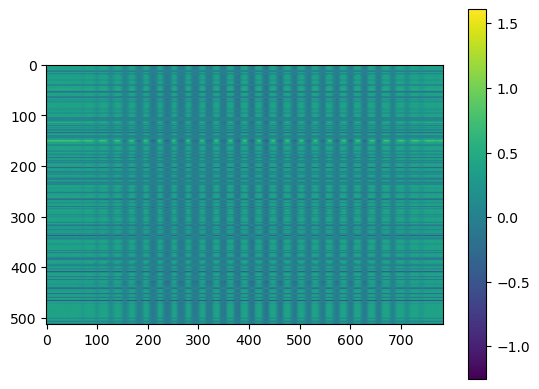

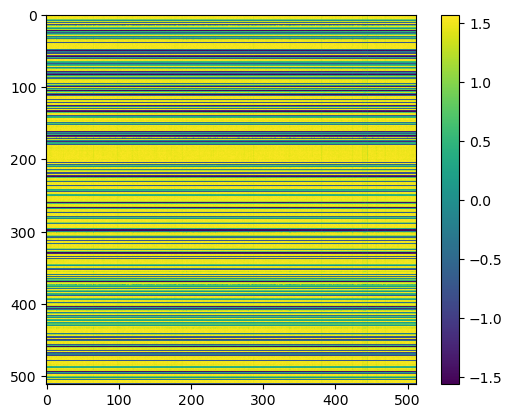

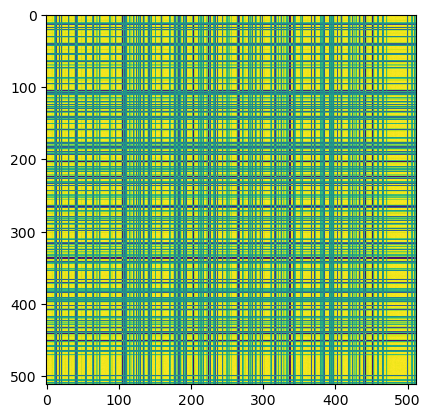

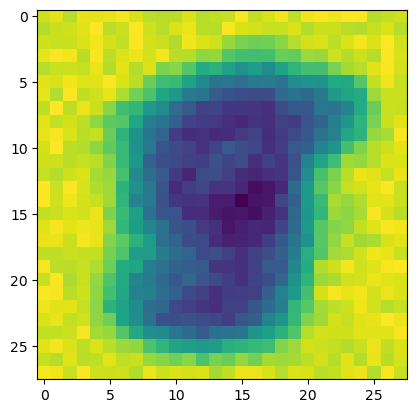

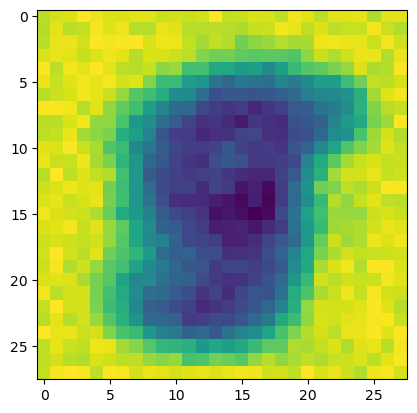

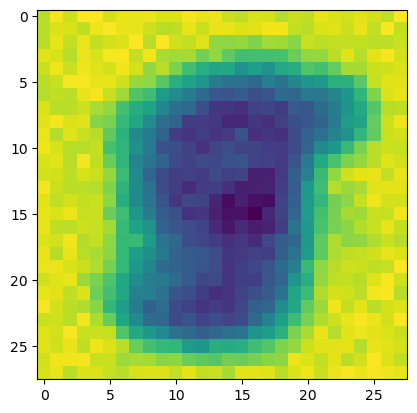

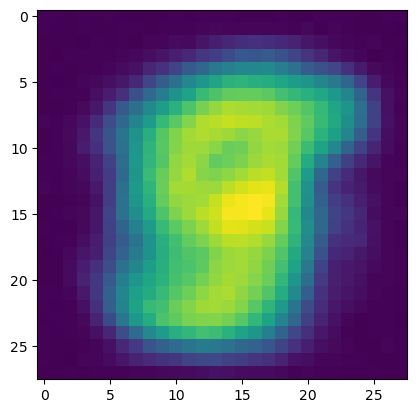

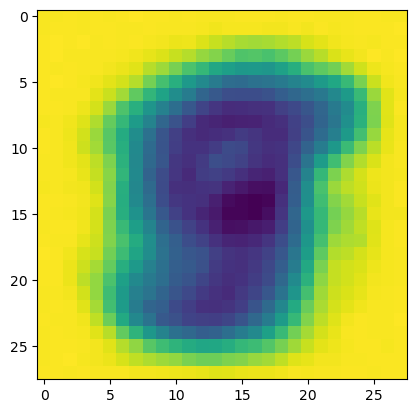

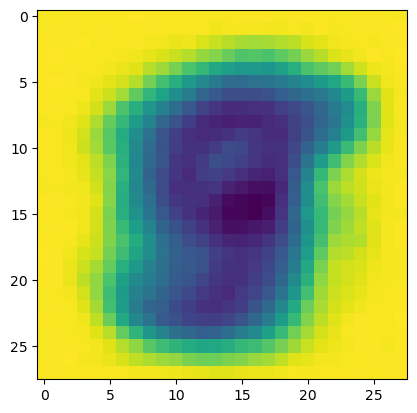

In [5]:
layers = [SNN.clapp[0].fc.weight]
for i in range(1, len(SNN.clapp)):
    layers.append(SNN.clapp[i].fc.weight @ layers[-1])

for i in range(len(SNN.clapp)):
    plt.figure()
    plt.imshow(SNN.clapp[i].fc.weight.detach())
    plt.colorbar()
plt.figure()
plt.imshow(SNN.clapp[0].pred.weight.detach())
plt.show()
for lay in layers:
    for i in range(100, 103):
        plt.figure()
        plt.imshow(lay[i].view(28, 28).detach())

In [6]:
print(len(clapp_activation))
hidden_activities_transformed = torch.stack(clapp_activation).swapaxes(0,1)
print((SNN.out_proj.out_proj.weight < 0).sum())

from sklearn.decomposition import PCA
import umap
umap = umap.UMAP()
pca = PCA(n_components=2)

colors = [color_list[i] for i in torch.tensor(target_list)]
pca = PCA(n_components=2)
for hat in hidden_activities_transformed:
    # hat_diff = hat[1:] - hat[:-1]
    hat_transform = umap.fit_transform(hat[::10].detach().cpu().numpy())
    # hat_transform = pca.fit_transform(hat.detach().cpu().numpy())
    print(hat_transform.shape)
    plt.figure()
    plt.plot(hat.cpu()[:50,3])
    plt.figure(figsize=(8,8))
    plt.scatter(hat_transform[:,0], hat_transform[:,1], s=6, c=colors[::10], alpha=0.4)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))


40000
tensor(3334)


ImportError: Numba needs NumPy 1.24 or less

# Train output Projection

999 tensor(3.8902)
1999 tensor(3.8808)
2999 tensor(3.6776)
3999 tensor(3.5485)
4999 tensor(3.6472)
5999 tensor(3.6343)
6999 tensor(3.6006)
7999 tensor(3.7657)
8999 tensor(3.5305)
9999 tensor(3.5508)
10999 tensor(3.6356)
11999 tensor(3.8146)
12999 tensor(3.7958)
13999 tensor(3.7571)
14999 tensor(3.7197)
15999 tensor(3.7077)
16999 tensor(3.7037)
17999 tensor(3.7958)
18999 tensor(3.7637)
19999 tensor(3.7862)
20999 tensor(3.8231)
21999 tensor(3.7470)
22999 tensor(3.8231)
23999 tensor(3.9713)
24999 tensor(3.9552)
25999 tensor(3.7831)
26999 tensor(3.8872)
27999 tensor(3.8111)
28999 tensor(3.8511)
29999 tensor(3.8031)
30999 tensor(3.8792)
31999 tensor(3.8351)
32999 tensor(3.8872)
33999 tensor(3.9032)
34999 tensor(3.8311)
35999 tensor(3.9392)
36999 tensor(3.8391)
37999 tensor(3.8672)
38999 tensor(3.9352)
39999 tensor(3.8672)
40999 tensor(3.8996)
41999 tensor(3.8712)
42999 tensor(3.8752)
43999 tensor(3.9021)
44999 tensor(3.8751)
45999 tensor(3.7150)
46999 tensor(3.8111)
47999 tensor(3.8151)
489

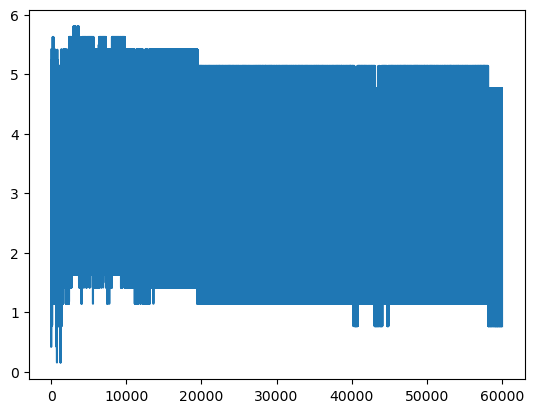

In [ ]:
# Gradient calculation + weight update
import snntorch.functional as SF
losses_out = []
SNN.out_proj.out_proj.reset_parameters()
optimizer = torch.optim.AdamW(SNN.out_proj.parameters(), lr=1e-3, weight_decay=1e-2)
loss_fn = SF.ce_count_loss()
SNN.train()
mem_his_list = []
for i, (data, target) in enumerate(train_loader):
    logit_list = []
    data = data.squeeze()
    for step in range(data.shape[0]):
        optimizer.zero_grad()
        data_step = data[step].float().to(device)
        target = target.to(device)
        logits, mem_his, clapp_loss = SNN(data_step, target, 0)
        mem_his_list.append(mem_his)
        logit_list.append(logits)
        optimizer.step()
    
    losses_out.append(loss_fn(torch.stack(logit_list).unsqueeze(1), target))
    
    if i % 1000 == 999:
        print(i, sum(losses_out[-999:])/999)
plt.plot(losses_out)

Parameter containing:
tensor([[-1.0308e+00, -3.3048e-03, -1.0327e+00,  ...,  2.2700e-03,
         -1.0286e+00, -1.0358e+00],
        [ 2.8331e+00,  2.3856e-03,  2.8314e+00,  ...,  3.4026e-03,
          2.8319e+00,  2.8334e+00],
        [-5.2250e-01, -2.8874e-03, -5.2295e-01,  ..., -2.1190e-03,
         -5.1977e-01, -5.2542e-01],
        ...,
        [ 8.0146e-01,  3.1780e-03,  8.0239e-01,  ..., -1.1044e-03,
          8.0338e-01,  8.0385e-01],
        [-1.0231e+00,  1.9628e-04, -1.0277e+00,  ...,  2.8112e-03,
         -1.0232e+00, -1.0276e+00],
        [-5.8221e-01, -1.0409e-03, -5.8932e-01,  ..., -4.4106e-05,
         -5.8940e-01, -5.8426e-01]], requires_grad=True)

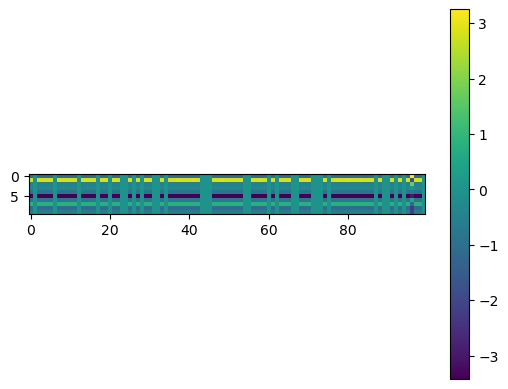

In [ ]:
plt.imshow(SNN.out_proj.out_proj.weight[:,:100].detach())
plt.colorbar()
SNN.out_proj.out_proj.weight

In [ ]:
SNN = CLAPP_SNN(n_inputs, n_hidden, n_outputs).to(device)
SNN.load_state_dict(torch.load('models/SNN_CLAPP_0.pt'))
losses, loss_per_digit, clapp_activation, target_list = test(SNN, test_loader, device)
print(loss_per_digit)
print('Mean Loss:', losses.sum()/10000)

10000it [01:56, 85.67it/s]


[tensor(4668.5688, device='cuda:0'), tensor(866.9744, device='cuda:0'), tensor(4916.2798, device='cuda:0'), tensor(4811.4790, device='cuda:0'), tensor(4678.0962, device='cuda:0'), tensor(4249.3657, device='cuda:0'), tensor(4563.7681, device='cuda:0'), tensor(785.2419, device='cuda:0'), tensor(4639.9868, device='cuda:0'), tensor(4806.7153, device='cuda:0')]
Mean Loss: tensor(3.8987, device='cuda:0')
